<a href="https://colab.research.google.com/github/KrishnaPavaniMunta/Professional-Project/blob/main/Denosing_Model_Preprocessing_FNIRS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Preprocessing Fnirs data
 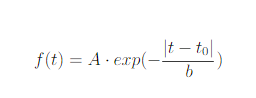https://mne.tools/stable/auto_tutorials/preprocessing/70_fnirs_processing.html



 Time period : 1000 samples 10000 seconds

In [1]:
!pip install matplotlib
!pip install numpy
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.5 MB/s eta 0:00:00


In [ ]:
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np

import mne

fnirs_data_folder = mne.datasets.fnirs_motor.data_path()
fnirs_cw_amplitude_dir = fnirs_data_folder / "Participant-1"
raw_intensity = mne.io.read_raw_nirx(fnirs_cw_amplitude_dir, verbose=True)
raw_intensity.load_data()

Using default location ~/mne_data for fnirs_motor...
Creating ~/mne_data


100%|█████████████████████████████████████| 17.9M/17.9M [00:00<00:00, 7.62GB/s]
Untarring contents of '/root/mne_data/MNE-fNIRS-motor-data.tgz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 04s (17.1 MB)
Loading /root/mne_data/MNE-fNIRS-motor-data/Participant-1
Reading 0 ... 23238  =      0.000 ...  2974.464 secs...


Measurement date,"November 02, 2019 13:16:16 GMT"
Experimenter,Unknown
Participant,P1
Digitized points,31 points
Good channels,56 fNIRS (CW amplitude)
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,7.81 Hz
Highpass,0.00 Hz
Lowpass,3.91 Hz


**Providing more meaningful annotation information**
First, we attribute more meaningful names to the trigger codes which are stored as annotations. Second, we include information about the duration of each stimulus, which was 5 seconds for all conditions in this experiment. Third, we remove the trigger code 15, which signaled the start and end of the experiment and is not relevant to our analysis.

In [ ]:
raw_intensity.annotations.set_durations(5)
raw_intensity.annotations.rename(
    {"1.0": "Control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
)
unwanted = np.nonzero(raw_intensity.annotations.description == "15.0")
raw_intensity.annotations.delete(unwanted)

**Selecting channels appropriate for detecting neural responses**

First we remove channels that are too close together (short channels) to detect a neural response (less than 1 cm distance between optodes). These short channels can be seen in the figure above. To achieve this we pick all the channels that are not considered to be short.


the term "neural response" is likely referring to these hemodynamic changes that indicate neural activity. When selecting channels for detecting neural responses, it's essential to ensure that the distance between the optodes (the sensors used in fNIRS) is appropriate. Channels that are too close together (less than 1 cm) might not effectively capture the hemodynamic changes associated with deeper brain activity because they are more sensitive to superficial tissue and might not penetrate deeply enough to detect neural responses accurately.

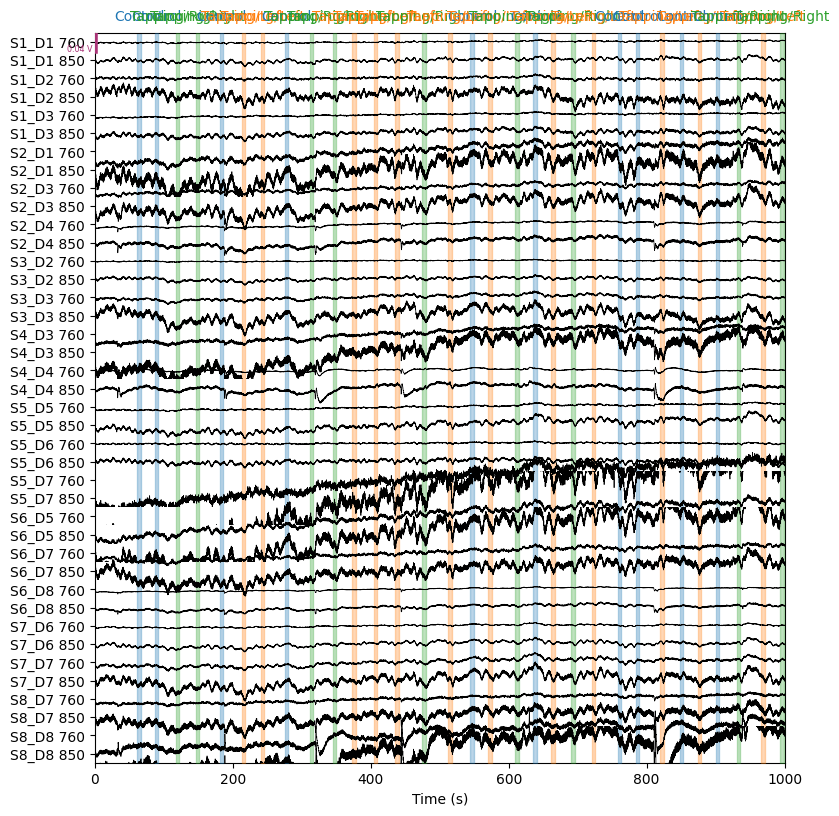

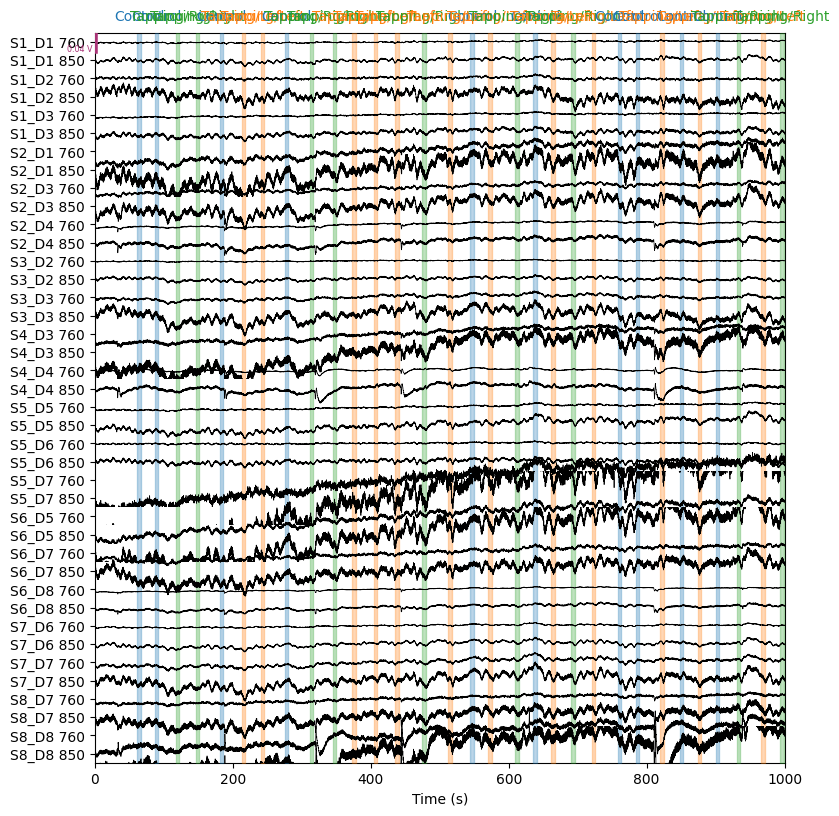

In [ ]:
picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(
    raw_intensity.info, picks=picks
)
raw_intensity.pick(picks[dists > 0.01])
raw_intensity.plot(
    n_channels=len(raw_intensity.ch_names), duration=1000, show_scrollbars=False
)

**Converting from raw intensity to optical density**

The raw intensity values are then converted to optical density.


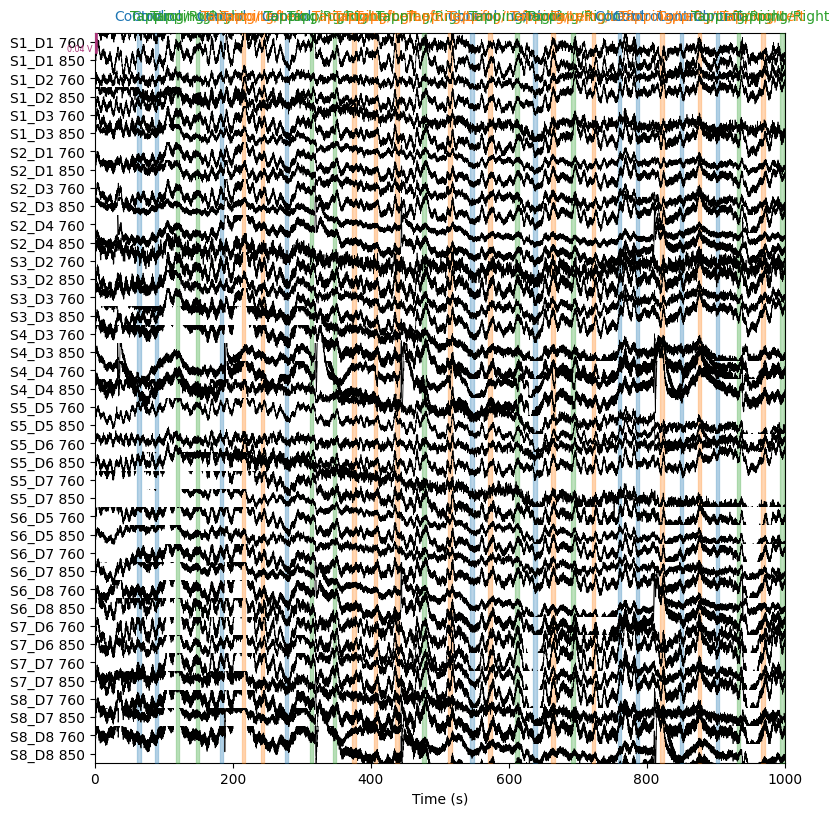

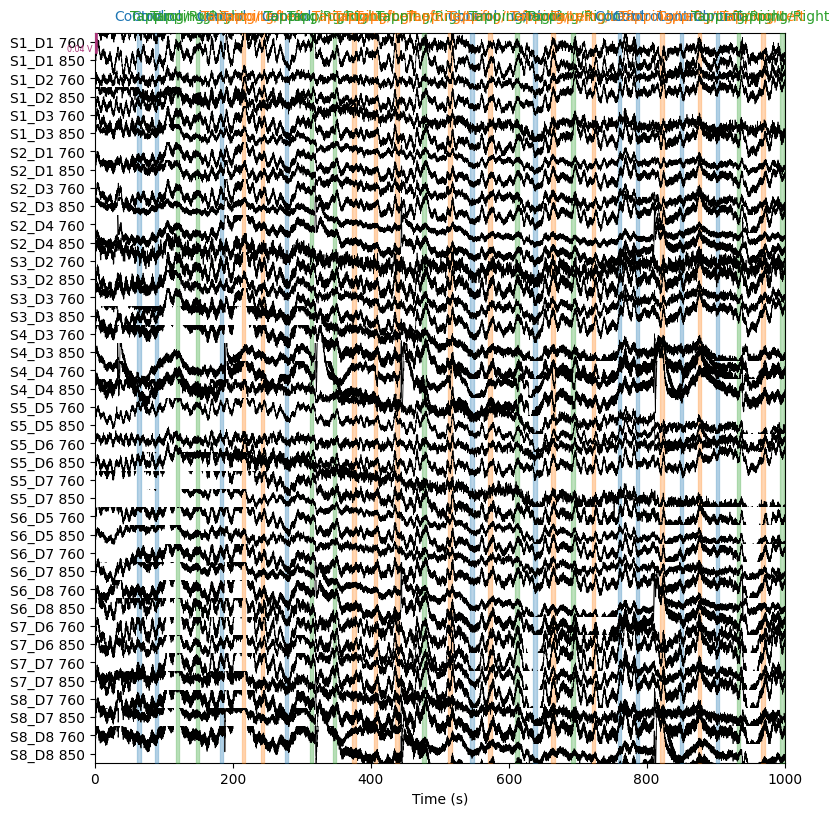

In [ ]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_od.plot(n_channels=len(raw_od.ch_names), duration=1000, show_scrollbars=False)

In [ ]:
from mne.simulation import simulate_sparse_stc
from mne.time_frequency import tfr_multitaper
from scipy.special import gamma

randomly selecting
values from a uniform distribution between 30 and 80 μM · mm, such that the DAE could learn
from a variety of learning samples. The HbR amplitude is always half of the HbO amplitude.

In [ ]:
 #Define parameters
sfreq = 10  # Sampling frequency (Hz)
n_samples = 10000  # Number of time points (10 minutes at 10 Hz)
t_peak = 0.7  # Time-to-peak in seconds (7 seconds)
duration = 2.0  # Duration in seconds (20 seconds)
amplitude_HbO = np.random.uniform(30e-6,80e-6)  # Desired increase in HbO concentration in µM
amplitude_HbR = amplitude_HbO/2  # Desired decrease in HbR concentration in µM

In [ ]:
# Create time vector
times = np.arange(n_samples) / sfreq

# Define the gamma function for the HRF
def gamma_hrf(t, peak, duration):
    return (t ** (peak - 1)) * np.exp(-t / duration) / ((duration ** peak) * gamma(peak))

In [ ]:
# Generate the HRF
hrf = gamma_hrf(times, t_peak, duration)

<ipython-input-37-2af7c7a399c0>:6: RuntimeWarning: divide by zero encountered in power
  return (t ** (peak - 1)) * np.exp(-t / duration) / ((duration ** peak) * gamma(peak))


In [ ]:
# Scale the HRF to the desired amplitudes
clean_hrf_hbo = amplitude_HbO * hrf
clean_hrf_hbr = amplitude_HbR * hrf

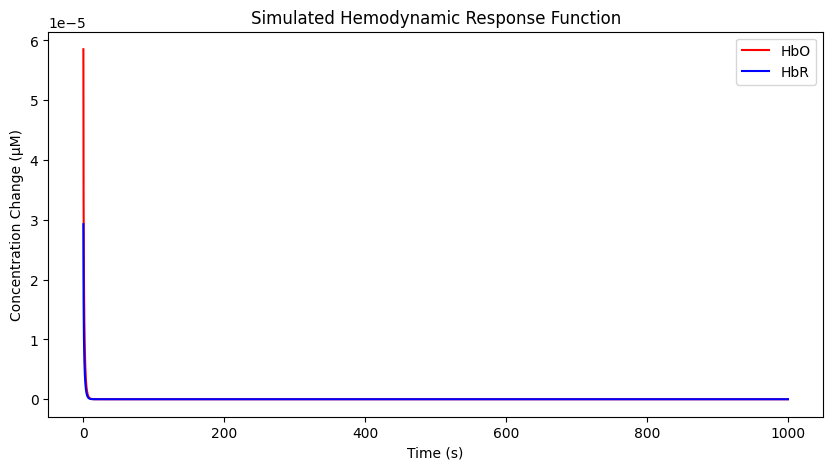

In [ ]:
# Plot the simulated HRF for HbO and HbR
plt.figure(figsize=(10, 5))
plt.plot(times, clean_hrf_hbo, 'r', label='HbO')
plt.plot(times, clean_hrf_hbr, 'b', label='HbR')
plt.xlabel('Time (s)')
plt.ylabel('Concentration Change (µM)')
plt.title('Simulated Hemodynamic Response Function')
plt.legend()
plt.show()

The motion artifacts contains two types: spike noise and shift noise

Spike noise can be simulated using the **Laplace Distribution function**

f(t) = A·exp(−|t−t0|/b)

A of 0.25 to 1uM

b of 0 to 1.5 seconds


In [ ]:
# Function to generate spike artifacts
def generate_spike_artifact(time, t0, A, b):
    return A * np.exp(-np.abs(time - t0) / b)

In [ ]:
num_spikes = np.random.randint(5, 11)
for _ in range(num_spikes):
    t0 = np.random.uniform(0, n_samples / sfreq)
    A = np.random.uniform(0.25e-6, 1e-6)
    b = np.random.uniform(0, 1.5)
    spike = generate_spike_artifact(times, t0, A, b)
    hrf_hbo += spike
    hrf_hbr += spike / 2  # Assuming the same artifact pattern for HbR

Shift noise was simulated as a positive or negative change in DC value of 0.125-0.5M with a linear transition lasting between 0.25 -1.5s


In [ ]:
# Add shift artifacts
num_shifts = np.random.randint(1, 4)
for _ in range(num_shifts):
    start_idx = np.random.randint(0, n_samples - int(20 * sfreq))
    end_idx = start_idx + np.random.randint(int(2 * sfreq), int(20 * sfreq))
    shift_value_hbo = np.random.uniform(0.25e-6, 1e-6)
    shift_value_hbr = shift_value_hbo / 2
    hrf_hbo[start_idx:end_idx] += shift_value_hbo
    hrf_hbr[start_idx:end_idx] += shift_value_hbr

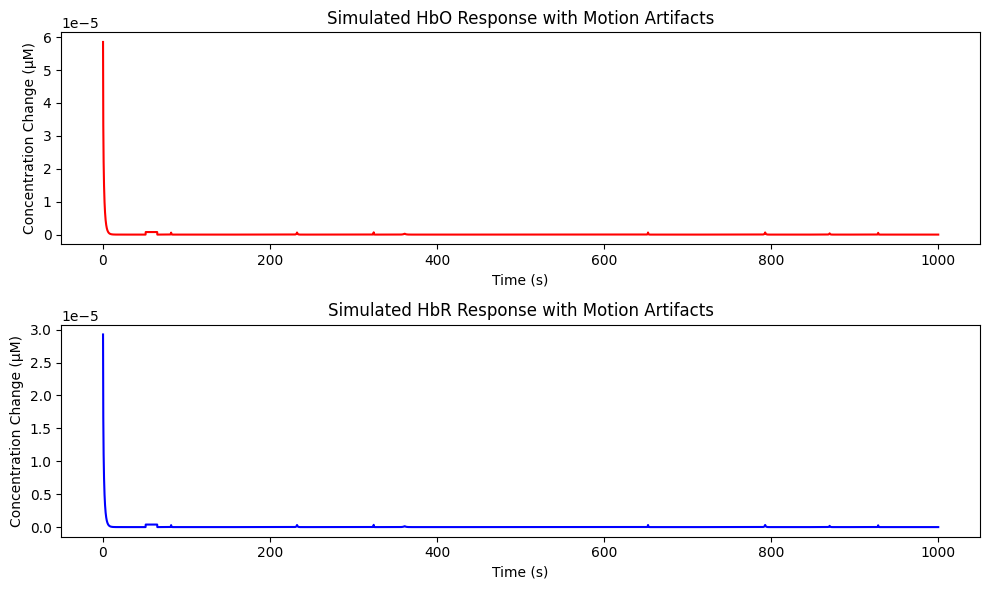

In [ ]:
# Plot the simulated HRF with artifacts
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(times, hrf_hbo, 'r')
ax[0].set_title('Simulated HbO Response with Motion Artifacts')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Concentration Change (µM)')
ax[1].plot(times, hrf_hbr, 'b')
ax[1].set_title('Simulated HbR Response with Motion Artifacts')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Concentration Change (µM)')
plt.tight_layout()
plt.show()

Next comes the Resting state data.

In [ ]:
!pip install statsmodels

Import the dependencies for resting state data

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

Generating Synthetic Resting state data

In [ ]:
np.random.seed(0)
n_samples = 1000
resting_state_data = np.random.randn(n_samples)

Fitting the AR model into resting state data

In [ ]:
ar_model = AutoReg(resting_state_data, lags=5)
ar_model_fitted = ar_model.fit()


In [ ]:

# Extract and print model parameters
params = ar_model_fitted.params
print("Model parameters:", params)
print("Number of parameters:", len(params))

Model parameters: [-0.05476541 -0.03362     0.01153635  0.03689024 -0.04357562 -0.0125389 ]
Number of parameters: 6


**Define ARIMA Model Correctly:**

Use ARIMA from statsmodels with the correct order (5, 0, 0) for an AR(5) model.
Ensure that the number of parameters passed matches the model's expectation.

In [ ]:
# Create AR model using fitted coefficients
arima_model = sm.tsa.arima.ARIMA(endog=resting_state_data, order=(5, 0, 0))

# Extract the variance from the fitted ARIMA model
params_variance = arima_model.fit().params[-1]

# Combine AR coefficients and variance
params = np.concatenate([params, [params_variance]])

In [ ]:
# Simulate resting-state data
Resting_state_data = arima_model.simulate(params=params, nsimulations=n_samples)

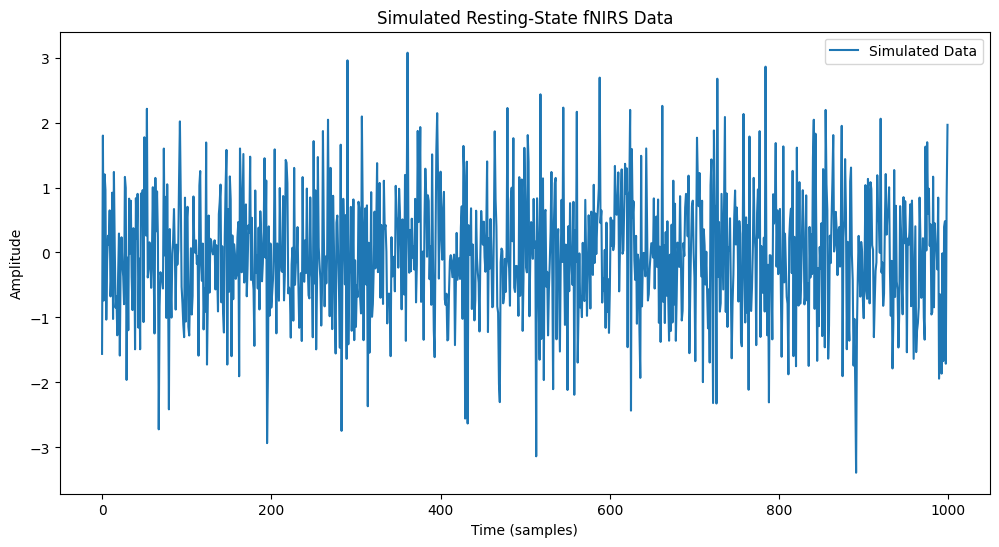

In [ ]:
# Plot the simulated data
plt.figure(figsize=(12, 6))
plt.plot(Resting_state_data, label='Simulated Data')
plt.title('Simulated Resting-State fNIRS Data')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# Generate HRF component using gamma functions
#from scipy.stats import gamma
'''
def gamma_hrf(t, params):
    hrf = params[0] * gamma.pdf(t, params[1]) - params[2] * gamma.pdf(t, params[3])
    return hrf

# Parameters for HRF simulation
TR = 0.1  # Temporal resolution in seconds
t = np.arange(0, n_samples * TR, TR)  # Time vector
gamma_params = [6, 0.9, 12, 0.9]  # [shape1, scale1, shape2, scale2]

# Generate HRF values
hrf_values = gamma_hrf(t, gamma_params)'''

# Random amplitude values from uniform distribution [30, 80] μM · mm
amplitudes = np.random.uniform(30, 80, n_samples)
clean_hrf = amplitudes * hrf_values[:len(amplitudes)]

# HbR amplitude is half of HbO amplitude
hbO_hrf = clean_hrf
hbR_hrf = hbO_hrf / 2

# Combine HRF, motion artifacts, and resting-state noise
synthetic_hbO_data = hbO_hrf + motion_artifacts + simulated_data
synthetic_hbR_data = hbR_hrf + motion_artifacts + simulated_data / 2

# Plotting the results (optional)
plt.figure(figsize=(12, 6))
plt.plot(synthetic_hbO_data, label='Synthetic HbO Data')
plt.title('Synthetic HbO Data with Motion Artifacts and Resting-State Noise')
plt.xlabel('Time (samples)')
plt.ylabel('Concentration (μM)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(synthetic_hbR_data, label='Synthetic HbR Data')
plt.title('Synthetic HbR Data with Motion Artifacts and Resting-State Noise')
plt.xlabel('Time (samples)')
plt.ylabel('Concentration (μM)')
plt.legend()
plt.show()
